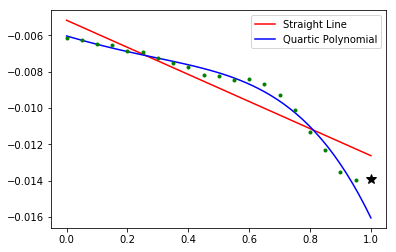

-0.0126321892989
-0.0126321892989
-0.0160586236062
-0.0160586236062
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
[0.00049645433818707048] [0.00049703569461377107] [0.00049540247895539893]
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)
(240809,)
(1123775,)
(240809,)

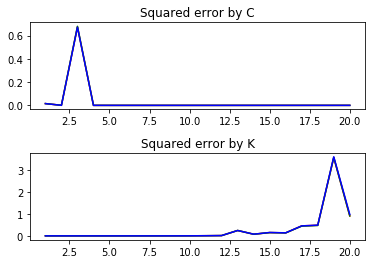

In [33]:
%matplotlib inline
import numpy as np
import scipy.io as io
import matplotlib
import matplotlib.pyplot as plt

## 1. Getting Started
#Data Reshape & Shuffle
amp_data = io.loadmat('/afs/inf.ed.ac.uk/group/teaching/mlprdata/audio/amp_data.mat')
arr_len = amp_data['amp_data'].shape[0]
split = int(int(arr_len/21)*21)
amp_data = amp_data['amp_data'][0:split,:].reshape(-1, 21)
np.random.shuffle(amp_data)

#Make train, validation, test sets
train_flag = int(amp_data.shape[0]*0.7)
valid_flag = train_flag+1
test_flag = valid_flag + int((amp_data.shape[0]-valid_flag)/2)
X_shuf_train = amp_data[0:train_flag,0:20]
y_shuf_train = amp_data[0:train_flag,20]
X_shuf_val = amp_data[valid_flag:test_flag,0:20]
y_shuf_val = amp_data[valid_flag:test_flag,20]
X_shuf_test = amp_data[test_flag:,0:20]
y_shuf_test = amp_data[test_flag:,20]

## 2. Curve fitting on a snippet of audio
x = np.array([list(float(i)/20.0 for i in range(20))])
y = X_shuf_train[0,:]
target = y_shuf_train[0]

#straight line
x_str = np.concatenate([np.ones((1,20)), x]).T
s_fit = np.linalg.lstsq(x_str, y)[0]
x_ = np.linspace(0,1)
str_eq = eval('x_*s_fit[1]+s_fit[0]')

#quartic polynomial
x_qua = np.concatenate([np.ones((1,20)), x, \
                        np.power(x,2), np.power(x,3), np.power(x,4)]).T
q_fit = np.linalg.lstsq(x_qua, y)[0]
qua_eq = eval('q_fit[0]+q_fit[1]*x_+q_fit[2]*x_**2+q_fit[3]*x_**3+q_fit[4]*x_**4')

plt.plot(x_, str_eq,'r')
plt.plot(x_, qua_eq, 'b')
plt.plot(x, y.reshape(1,20), 'g.')
plt.plot(1.0, target, 'k*', markersize=10)
plt.legend(["Straight Line","Quartic Polynomial"])
plt.show()

## 3. Choosing a polynomial predictor based on performance

def Phi(C, K):
    phi_matrix = []
    for i in [float(t)/20.0 for t in range(20-C,20)]:
        feature = []
        for j in range(K+1):
            feature.append(i**j)
        phi_matrix.append(feature)
    return np.array(phi_matrix)

def make_vv(C, K):
    features = Phi(C,K)
    phi_1 = np.ones(K+1)
    return np.linalg.inv(features.T.dot(features)).dot(features.T).T.dot(phi_1)

#predictions
vector_K1 = make_vv(20,1)
print(1.0*s_fit[1]+s_fit[0])
print(vector_K1.dot(y.T))

vector_K4 = make_vv(20,4)
x_=1.0
print(q_fit[0]+q_fit[1]*x_+q_fit[2]*x_**2+q_fit[3]*x_**3+q_fit[4]*x_**4)
print(vector_K4.dot(y.T))

def square_error(y, f_x):
    return (y-f_x)**2

def mean_squared_error(Y, X):
    return np.sum([np.power(Y-X,2)])/Y.shape[0]

#evaluate predictors 
res_C_train =[]
res_C_val =[]
res_C_test =[]
for i in range(1,21):
    vector = make_vv(i,4)
    res_C_train.append(mean_squared_error(y_shuf_train, vector.dot(X_shuf_train[:,20-i:20].T)))
    res_C_val.append(mean_squared_error(y_shuf_val, vector.dot(X_shuf_val[:,20-i:20].T)))
    res_C_test.append(mean_squared_error(y_shuf_test, vector.dot(X_shuf_test[:,20-i:20].T)))

res_K_train =[]
res_K_val =[]
res_K_test =[]
for i in range(1,21):
    vector = make_vv(20,i)
    res_K_train.append(mean_squared_error(y_shuf_train, vector.dot(X_shuf_train.T)))
    res_K_val.append(mean_squared_error(y_shuf_val, vector.dot(X_shuf_val.T)))
    res_K_test.append(mean_squared_error(y_shuf_test, vector.dot(X_shuf_test.T)))
    if(i==1):
        print(res_K_train[0:3],res_K_val[0:3],res_K_test[0:3])
        
f, ax = plt.subplots(2)
f.subplots_adjust(hspace=0.5)

ax[0].plot(np.arange(1,21), res_C_train, 'r')
ax[0].plot(np.arange(1,21), res_C_val, 'g')
ax[0].plot(np.arange(1,21), res_C_test, 'b')
ax[0].set_title('Squared error by C')
ax[1].plot(np.arange(1,21), res_K_train, 'r')
ax[1].plot(np.arange(1,21), res_K_val, 'g')
ax[1].plot(np.arange(1,21), res_K_test, 'b')
ax[1].set_title('Squared error by K')
plt.show()